In [1]:
import isaacgym
import isaacgymenvs
from isaacgymenvs.utils.reformat import omegaconf_to_dict, print_dict
from isaacgymenvs.utils.utils import set_np_formatting, set_seed
from isaacgymenvs.utils.rlgames_utils import RLGPUEnv, RLGPUAlgoObserver, get_rlgames_env_creator

from rl_games.common import env_configurations, vecenv
from rl_games.torch_runner import Runner
from rl_games.algos_torch import model_builder

from omegaconf import DictConfig, OmegaConf

import torch
import numpy as np
import matplotlib.pyplot as plt

Importing module 'gym_38' (/home/hz/devel/isaacgym/python/isaacgym/_bindings/linux-x86_64/gym_38.so)
Setting GYM_USD_PLUG_INFO_PATH to /home/hz/devel/isaacgym/python/isaacgym/_bindings/linux-x86_64/usd/plugInfo.json


PyTorch version 2.0.0
Device count 1
/home/hz/devel/isaacgym/python/isaacgym/_bindings/src/gymtorch


Using /home/hz/.cache/torch_extensions/py38_cu117 as PyTorch extensions root...
Emitting ninja build file /home/hz/.cache/torch_extensions/py38_cu117/gymtorch/build.ninja...
Building extension module gymtorch...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


ninja: no work to do.


Loading extension module gymtorch...
2023-05-04 18:19:11,701 - INFO - logger - logger initialized
<unknown>:3: DeprecationWarning: invalid escape sequence \*
/home/hz/miniforge3/envs/rlgpu/lib/python3.8/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
/home/hz/miniforge3/envs/rlgpu/lib/python3.8/site-packages/matplotlib/__init__.py:169: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
/home/hz/miniforge3/envs/rlgpu/lib/python3.8/site-packages/setuptools/_distutils/version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Error: FBX library failed to load - importing FBX data will not succeed. Message: No module named 'fbx'
FBX tools must be installed from https://help.autodesk.com/view/FBX/2020/ENU/?guid=FBX_Developer_Help_scripting_with_python_fbx_installing_python_fbx_html


In [2]:
cfg = OmegaConf.load("../isaacgymenvs/cfg/config.yaml")
cfg.task_name="TrifingerNYU"
cfg.num_envs=1
cfg.task=OmegaConf.load("../isaacgymenvs/cfg/task/TrifingerNYU.yaml")

In [3]:
device = cfg.sim_device

In [4]:
def create_env_thunk(**kwargs):
        envs = isaacgymenvs.make(
            
            cfg.seed,
            cfg.task,
            cfg.num_envs,
            cfg.sim_device,
            cfg.rl_device,
            headless=True,
            cfg=cfg,
            **kwargs,
        )
        return envs

In [5]:
envs = create_env_thunk()

/home/hz/miniforge3/envs/rlgpu/lib/python3.8/site-packages/gym/spaces/box.py:112: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/home/hz/learning/IsaacGymEnvs/isaacgymenvs/tasks/trifingerNYU.py:1279: DeprecationWarning: an integer is required (got type isaacgym._bindings.linux-x86_64.gym_38.DofDriveMode).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  robot_asset_options.default_dof_drive_mode = gymapi.DOF_MODE_EFFORT


[Warning] [carb.gym.plugin] useGpu is set, forcing single scene (0 subscenes)
Not connected to PVD
+++ Using GPU PhysX
Physics Engine: PhysX
Physics Device: cuda:0
GPU Pipeline: enabled
Trifinger Robot Asset: 
	 Number of bodies: 23
	 Number of shapes: 39
	 Number of dofs: 9
	 Number of actuated dofs: 9
Trifinger Table Asset: 
	 Number of bodies: 2
	 Number of shapes: 1
Trifinger Boundary Asset: 
	 Number of bodies: 1
	 Number of shapes: 41
Using VHACD cache directory '/home/hz/.isaacgym/vhacd'
Found existing convex decomposition for mesh '/home/hz/learning/IsaacGymEnvs/isaacgymenvs/../assets/trifinger/robot_properties_fingers/meshes/pro/int_sim.stl'
Found existing convex decomposition for mesh '/home/hz/learning/IsaacGymEnvs/isaacgymenvs/../assets/trifinger/robot_properties_fingers/meshes/pro/prox-sim.stl'
Found existing convex decomposition for mesh '/home/hz/learning/IsaacGymEnvs/isaacgymenvs/../assets/trifinger/robot_properties_fingers/meshes/pro/tip_link_sim.stl'
Found existing co

In [6]:
# get fingertip states
N = 500
action_buffer = torch.zeros(N, 9).to(device)
ftip_pos_buffer = torch.zeros(N, 9).to(device)
ftip_vel_buffer = torch.zeros(N, 9).to(device)
jacobian_buffer = torch.zeros(N, 9, 9).to(device)
dof_vel_buffer = torch.zeros(N, 9).to(device)

for n in range(N):
    action = torch.rand(1, 9).to(device) * 2 - 1
    obs, rwds, resets, info = envs.step(torch.rand(1, 9).to(cfg.sim_device) * 2 - 1)
    action_buffer[n] = action
    
    q = envs._dof_position
    dq = envs._dof_velocity
    dof_vel_buffer[n] = dq[0]
    
    fingertip_state = envs._rigid_body_state[:, envs._fingertip_indices]
    fingertip_position = fingertip_state[:, :, 0:3].reshape(envs.num_envs, 9)
    fingertip_velocity = fingertip_state[:, :, 7:10].reshape(envs.num_envs, 9)
    ftip_pos_buffer[n] = fingertip_position[0]
    ftip_vel_buffer[n] = fingertip_velocity[0]
    
    fid = [5, 12, 19]
    jacobian_fingertip_linear = envs._jacobian[:, fid, :3, :]
    jacobian_fingertip_linear = jacobian_fingertip_linear.view(
                    envs.num_envs, 
                    3 * envs._dims.NumFingers.value, 
                    envs._dims.GeneralizedCoordinatesDim.value)
    jacobian_buffer[n] = jacobian_fingertip_linear[0]

In [7]:
ftip_pos_buffer_np = ftip_pos_buffer.cpu().numpy()
ftip_vel_buffer_np = ftip_vel_buffer.cpu().numpy()
jdq = torch.einsum('bij, bj -> bi', jacobian_buffer, dof_vel_buffer)
jdq_np = jdq.cpu().numpy()

In [8]:
dt = 0.02
ftip_vel_numdiff = np.diff(ftip_pos_buffer_np, axis=0) / dt
ftip_vel_numdiff = np.vstack((np.zeros((1, 9)), ftip_vel_numdiff))

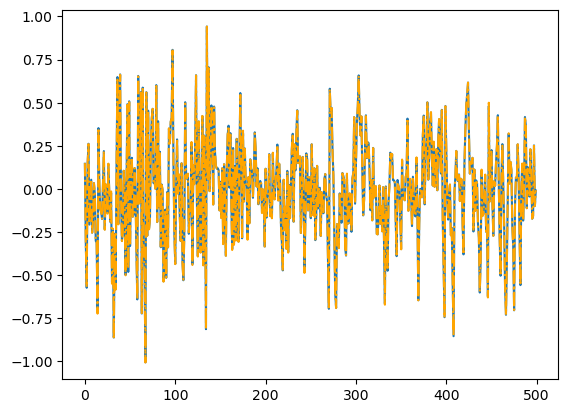

In [9]:
d = 0
# plt.plot(ftip_vel_numdiff[:, d])
plt.plot(ftip_vel_buffer_np[:, d])
plt.plot(jdq_np[:, d], color='orange', ls='-.')